In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from utils import fitR0
import networkx as nx
from utils import SIR_net_adaptive
import utils
import multiprocessing as mp
import time
import random

Testing the effect of rewiring in the information network

In [115]:
N = 1000 # number of nodes
ave_degree = 10
initial_no_vax = np.arange(100, 300)

G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
G_info_static = G_phys.copy()
utils.initNET_rnd(G_info_static, initial_no_vax)

In [116]:
g = G_info_static
deg = list(dict(g.degree).values())
np.mean(deg)

9.95

In [1]:
# def random_edge(graph):

#     nonedges = list(nx.non_edges(graph))
    
#     for i in range(100):
#         # random edge choice
#         chosen_nonedge = random.choice([x for x in nonedges])

#         # add new edge
#         graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])

#     return graph

In [2]:
# T=True

# while T:
#     G_info_static = random_edge(G_info_static)
    
#     g = G_info_static
#     deg = list(dict(g.degree).values())
#     if np.mean(deg)>=25:
#         T=False

In [3]:
# g = G_info_static
# deg = list(dict(g.degree).values())
# np.mean(deg)

In [46]:
G_info_dynamic = G_info_static.copy()

In [2]:
# N = 1000 # number of nodes
# ave_degree = 10
# p = ave_degree / N  # edge probability
initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
# initial_no_vax = np.arange(100, 300)
#initial_no_vax = 300

mu = 1 / 7       # recovery rate
beta = 3 / 140    # infection rate
pro = 0.      # rate of classical media influence on people
pol = 0.3      # propensity of opinion polarization
r = 0.1        # rate of vaccination for PV
#gamma = 0.5
#nmax = 100

# G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
# G_info_static = G_phys.copy()
# #utils.initNET_SI(G_info_static, I0=initial_no_vax, I_seed=np.arange(10)) # initialize information network
# utils.initNET_rnd(G_info_static, initial_no_vax)
# G_info_dynamic = G_info_static.copy()


sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False)
sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds)

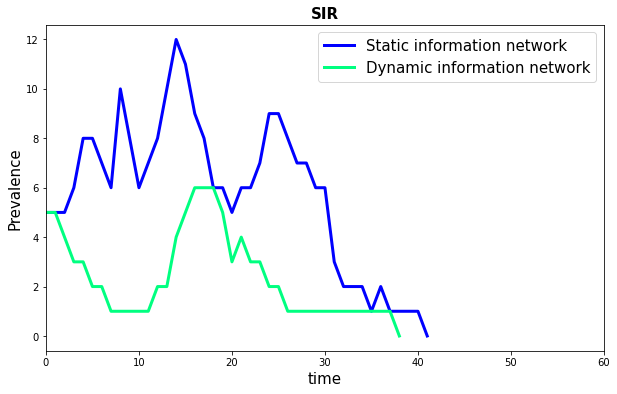

In [22]:
colors = cm.get_cmap('winter', 2)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
ax.plot(sim_static[0], sim_static[2], lw=3, c=colors(0), label= "Static information network", alpha=1)
ax.plot(sim_dynamic[0], sim_dynamic[2], lw=3, c=colors(1), label= "Dynamic information network", alpha=1)
ax.set_title('SIR', fontweight='bold', size=15)
ax.legend(fontsize=15)
ax.set_ylabel("Prevalence", size=15)
ax.set_xlabel("time", size=15)
ax.set_xlim(0, 60);

infoNET clustering coefficients:
static: 0.037373457645105426
dynamic: 0.10790089978496542


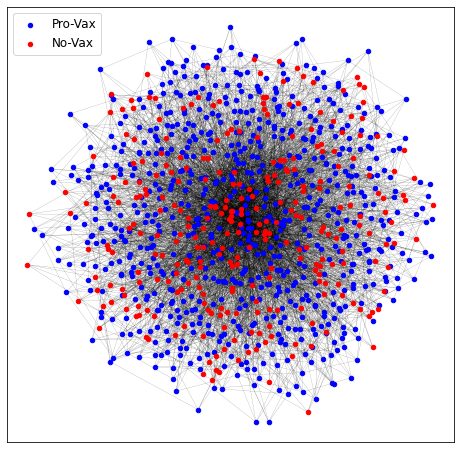

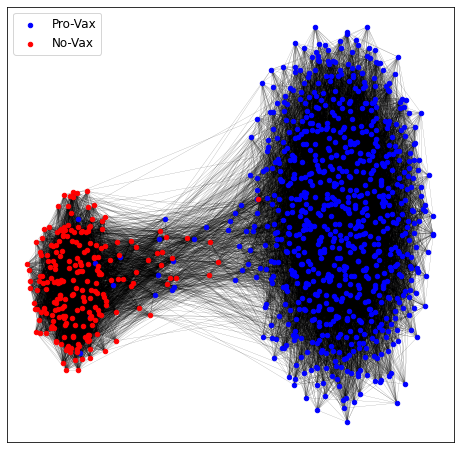

In [23]:
print('infoNET clustering coefficients:')
print('static:', nx.algorithms.cluster.average_clustering(G_info_static))
print('dynamic:', nx.algorithms.cluster.average_clustering(G_info_dynamic))
utils.plot_info_network(G_info_static)
utils.plot_info_network(G_info_dynamic)

Da quì in poi non va, bisogna riadattarlo alla funzione SIR_net_adaptive

In [2]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 15
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 0.1       # recovery rate
    beta = 0.15    # infection rate
    pro = 0.      # rate of classical media influence on people
    pol = 0.5      # propensity of opinion polarization
    r = 0.3       # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [3]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [4]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

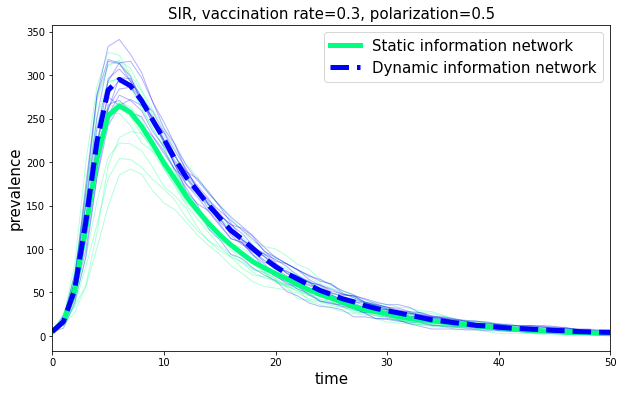

In [5]:
r = 0.3
pol = 0.5
colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

### Prove Michele al variare di beta

In [47]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 1/7       # recovery rate
    beta = 0.35    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)


nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


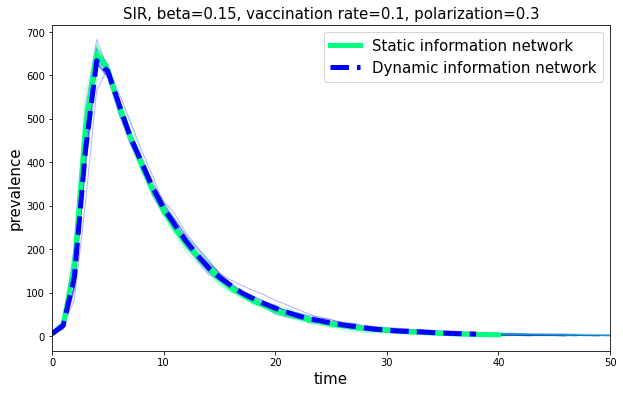

In [48]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)


beta = 0.35    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

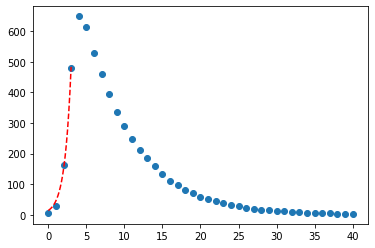

G = 1.1820444001585928

R0 = 9.27431080111015


In [51]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 4)

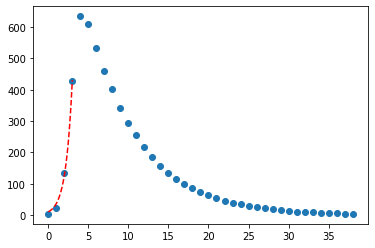

G = 1.2237837692667501

R0 = 9.56648638486725


In [52]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 4)

In [56]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 1/7       # recovery rate
    beta = 0.15    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [57]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [58]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

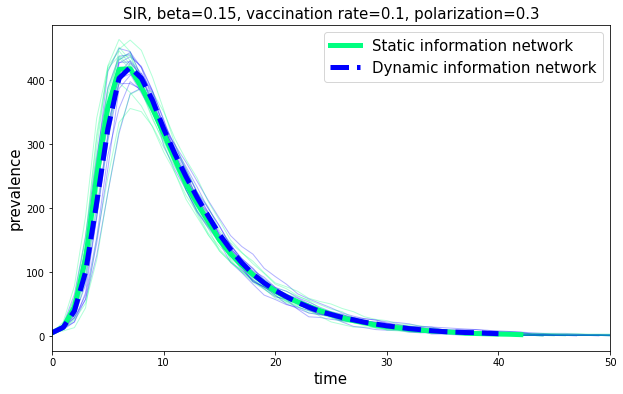

In [59]:
beta = 0.15    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

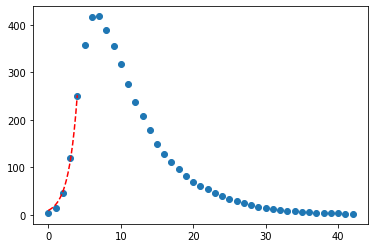

G = 0.8214282566222144

R0 = 6.749997796355501


In [62]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 5)

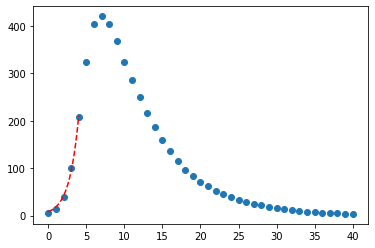

G = 0.8108163467254506

R0 = 6.675714427078153


In [63]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

In [64]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 1/7       # recovery rate
    beta = 0.1     # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [65]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [66]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

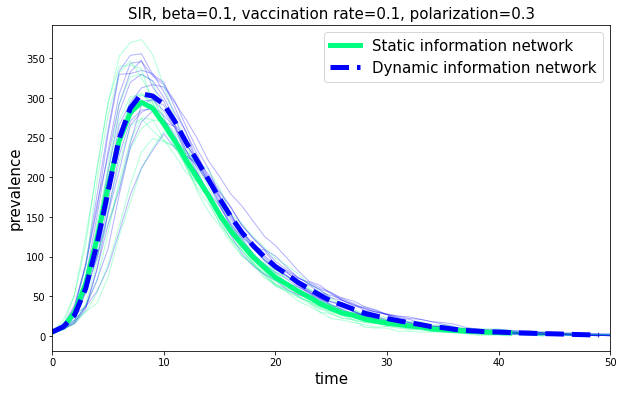

In [67]:
beta = 0.1     # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

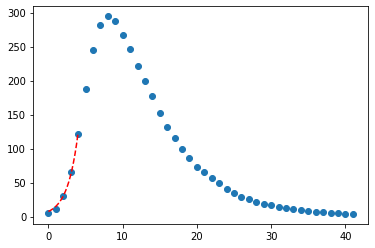

G = 0.702294025704217

R0 = 5.916058179929519


In [69]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 5)

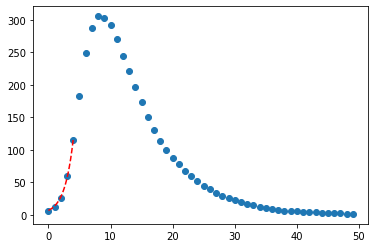

G = 0.7188959751895733

R0 = 6.032271826327013


In [71]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

In [72]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100, 300)


    mu = 1/7       # recovery rate
    beta = 0.08    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [73]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [74]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

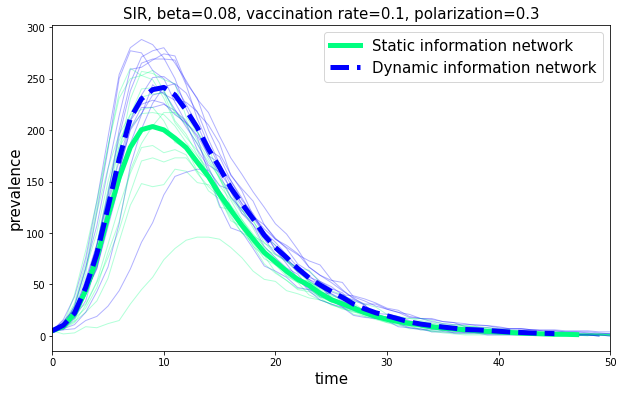

In [75]:
beta = 0.08    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

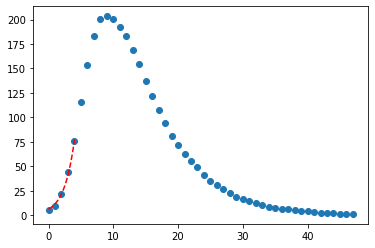

G = 0.631393313842392

R0 = 5.419753196896743


In [77]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 5)

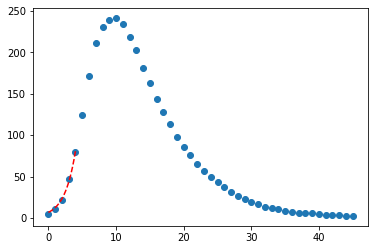

G = 0.6258942107824848

R0 = 5.3812594754773935


In [80]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

In [81]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100, 300)


    mu = 1/7       # recovery rate
    beta = 0.07    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [82]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [83]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

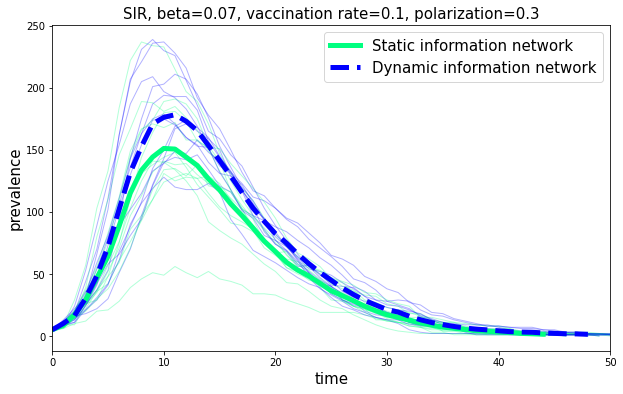

In [84]:
beta = 0.07    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

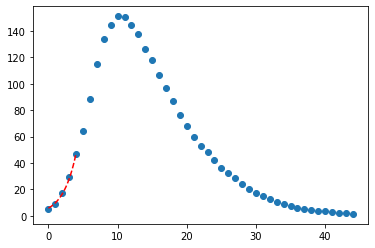

G = 0.525315005543287

R0 = 4.6772050388030095


In [87]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 5)

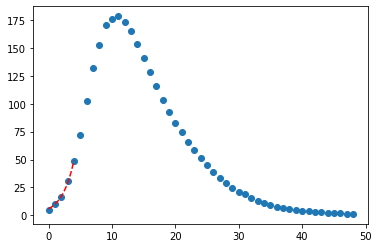

G = 0.5297596206277226

R0 = 4.708317344394058


In [90]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

In [91]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100, 300)


    mu = 1/7       # recovery rate
    beta = 0.06    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [92]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [93]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

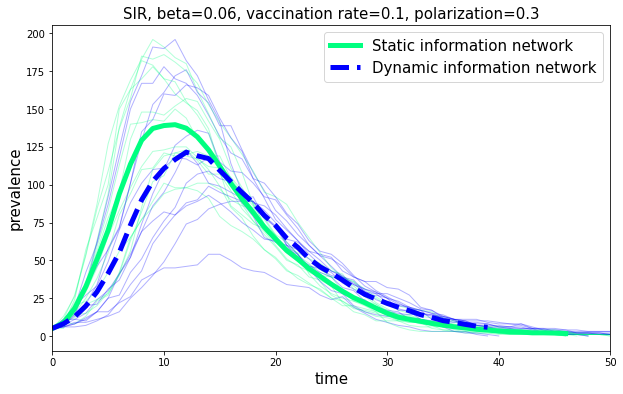

In [94]:
beta = 0.06    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

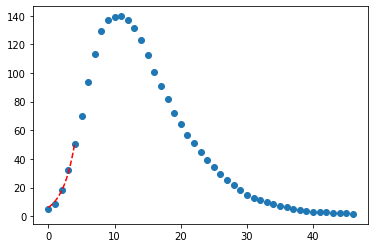

G = 0.5316459040407772

R0 = 4.721521328285441


In [97]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 5)

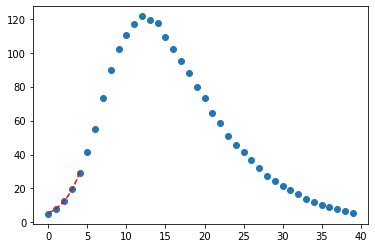

G = 0.42430599577978856

R0 = 3.9701419704585197


In [98]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

In [100]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 1/7       # recovery rate
    beta = 0.05    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [101]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [102]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

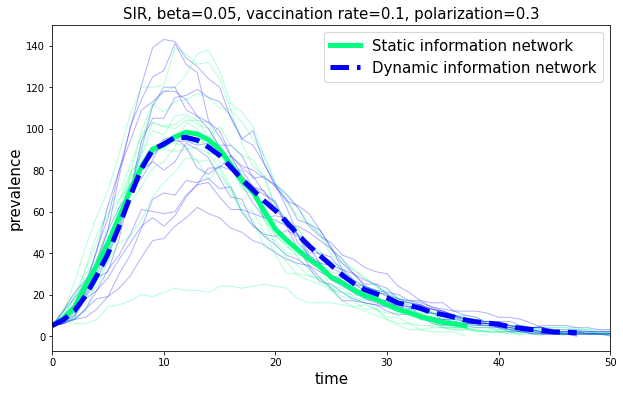

In [103]:
beta = 0.05    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

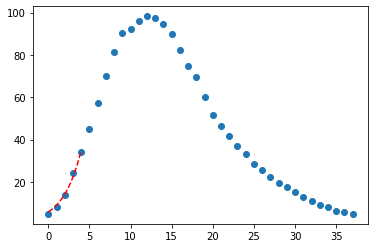

G = 0.4489122734688213

R0 = 4.142385914281749


In [105]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 5)

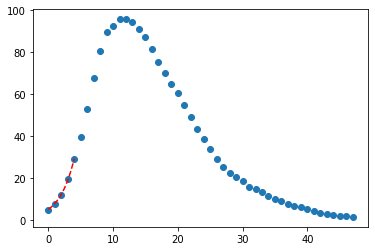

G = 0.4352061373417508

R0 = 4.0464429613922555


In [106]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

In [107]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 1/7       # recovery rate
    beta = 0.04    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [108]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [109]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

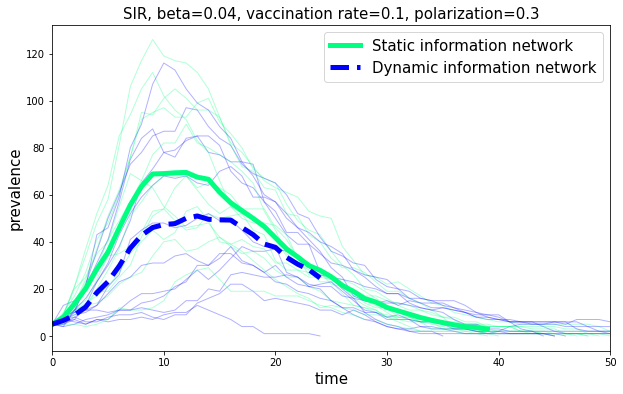

In [110]:
beta = 0.04    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

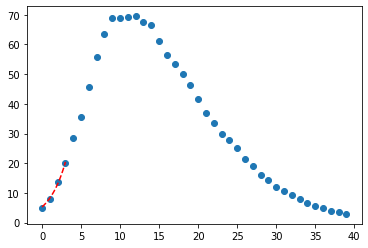

G = 0.452714667674595

R0 = 4.169002673722165


In [112]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 4)

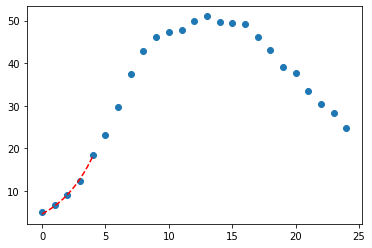

G = 0.3435614249047733

R0 = 3.404929974333413


In [114]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 5)

## R0 Exponential Fit Estimation

In [60]:
# Una volta fatte le simulazioni e calcolate le traiettorie medie si può fare calcolare R0 in questo modo
# R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 8)

## Simulazioni al variare del numero iniziale di novax

Influisce sull'incidenza, ma non sulla separazione delle curve statico/dinamico

### 200 no vax

In [159]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100, 300)


    mu = 1/7       # recovery rate
    beta = 0.07    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [160]:
nsim = 24
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [161]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

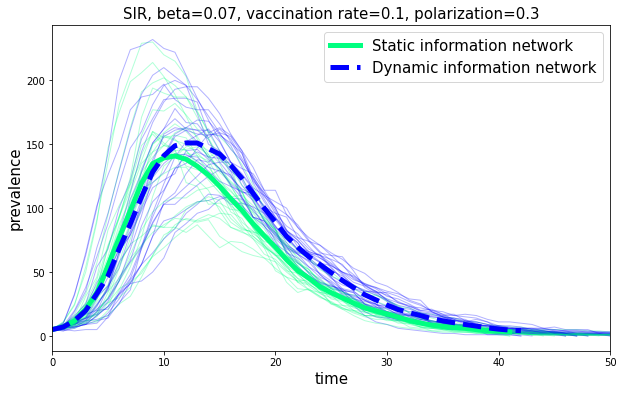

In [162]:
beta = 0.07    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

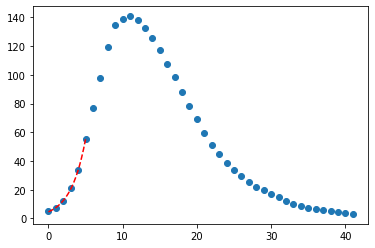

G = 0.4960344314796373

R0 = 4.472241020357462


In [163]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 6)

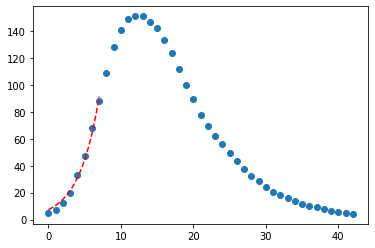

G = 0.3605877718095943

R0 = 3.52411440266716


In [164]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 8)

### 500 no vax

In [165]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100, 600)


    mu = 1/7       # recovery rate
    beta = 0.07    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [166]:
nsim = 24
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [167]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

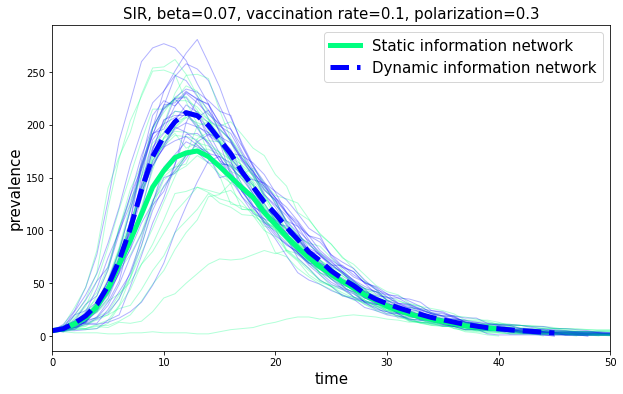

In [168]:
beta = 0.07    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

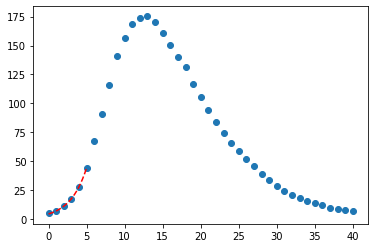

G = 0.46151576314569176

R0 = 4.230610342019842


In [169]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 6)

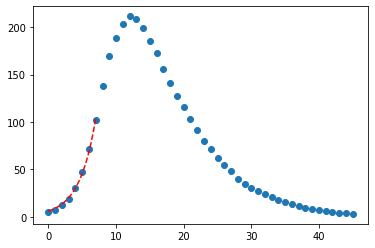

G = 0.41034461552913937

R0 = 3.8724123087039755


In [170]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 8)

### 900 no vax

In [153]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 10
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100, 1000)


    mu = 1/7       # recovery rate
    beta = 0.08    # infection rate
    pro = 0.       # rate of classical media influence on people
    pol = 0.3      # propensity of opinion polarization
    r = 0.1        # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [154]:
nsim = 24
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [155]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

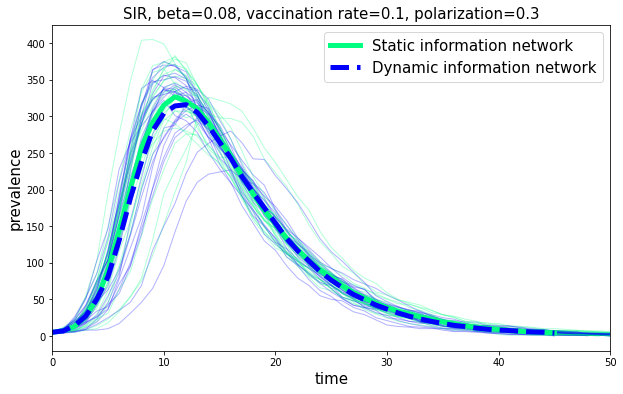

In [156]:
beta = 0.08    # infection rate
pol = 0.3      # propensity of opinion polarization
r = 0.1   

colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, beta={beta}, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

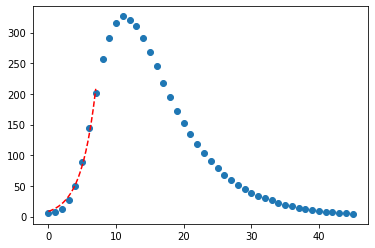

G = 0.45886498454548674

R0 = 4.212054891818408


In [157]:
R0 = fitR0(np.arange(minlen_static_I), ave_I_stat, start = 0, n_points = 8)

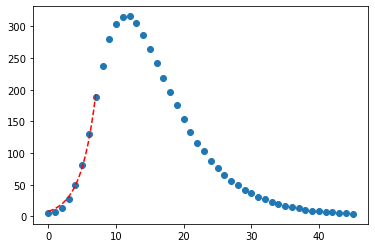

G = 0.4549407102924097

R0 = 4.184584972046868


In [158]:
R0 = fitR0(np.arange(minlen_dynamic_I), ave_I_dyn, start = 0, n_points = 8)